# Predictive Pricing of Apartments in São Paulo

# Section 1: Setup

In [1]:
# Importing the libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from geopy.geocoders import Nominatim
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import folium
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import geopandas as gpd
import libpysal
from spreg import OLS
import statsmodels.api as sm

warnings.filterwarnings("ignore")

# Section 2: Data Understanding

#### Dataset Overview
The dataset we will be working with contains information on apartments in São Paulo, with the following columns:

id: Unique identifier for each apartment. <br>
valor_total: Total price of the apartment in Brazilian Reais (BRL). <br>
unit: Price per square meter in BRL. <br>
area_util: Total usable area in square meters.<br>
quartos: Number of bedrooms.<br>
vagas: Number of parking spaces.<br>
condominio: Condominium fee in BRL.<br>
suites: Number of suites.<br>
banheiros: Number of bathrooms.<br>
piscina: Binary indicator for the presence of a swimming pool.<br>
academia: Binary indicator for the presence of a gym.<br>
quadra: Binary indicator for the presence of a sports court.<br>
endereco: Address of the apartment.<br>
link: Link to the apartment listing.<br>
bairro: Neighborhood where the apartment is located.<br>
media_bairro: Average apartment price in the neighborhood.<br>
qtd_dados_bairro: Number of data points available for the neighborhood.<br>
media_idh: Average Human Development Index (IDH) in the neighborhood.<br>
media_gini: Average Gini Index in the neighborhood.<br>
expectativa_vida: Life expectancy in the neighborhood.<br>
renda_percapita: Per capita income in the neighborhood.<br>
estacao_prox: Nearest subway station to the apartment.<br>
linha_prox: Subway line serving the nearest station.<br>
dist: Distance from the apartment to the nearest subway station in meters.<br>
lat: Latitude of the apartment's location.<br>
lon: Longitude of the apartment's location.<br>

In [2]:
# Importing the database
df = pd.read_excel('/Users/joaosequeira/sao_paulo_apartments/sao_paulo_apartments/dados_wgs.xlsx')
df


,id,valor_total,unit,area_util,quartos,vagas,condominio,suites,banheiros,piscina,...,qtd_dados_bairro,media_idh,media_gini,expectativa_vida,renda_percapita,estacao_prox,linha_prox,dist,lat,lon
0,526,189900,5934.38,32,2,1,180.0,0,1,0,...,36.0,0.697182,0.410909,72.751818,559.668182,SÃO MATEUS,PRATA,6822.823684,-23.583879,-46.417548
1,734,221110,5142.09,43,2,1,250.0,0,1,0,...,36.0,0.697182,0.410909,72.751818,559.668182,CORINTHIANS-ITAQUERA,VERMELHA,4682.709841,-23.543535,-46.425492
2,738,219990,5116.05,43,1,1,300.0,0,1,1,...,36.0,0.697182,0.410909,72.751818,559.668182,CORINTHIANS-ITAQUERA,VERMELHA,4579.311123,-23.537339,-46.426823
3,753,219990,5116.05,43,2,1,300.0,0,1,1,...,36.0,0.697182,0.410909,72.751818,559.668182,CORINTHIANS-ITAQUERA,VERMELHA,4579.311123,-23.537339,-46.426823
4,924,220000,5365.85,41,2,1,300.0,0,1,1,...,36.0,0.697182,0.410909,72.751818,559.668182,CORINTHIANS-ITAQUERA,VERMELHA,3313.918703,-23.557799,-46.443523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,2232,400000,6557.38,61,1,0,NaN,0,1,0,...,17.0,0.839667,0.510000,79.776667,1691.543333,REPÚBLICA,AMARELA,517.307020,-23.549233,-46.644282
2495,2233,688000,4712.33,146,2,1,600.0,1,3,0,...,17.0,0.839667,0.510000,79.776667,1691.543333,REPÚBLICA,AMARELA,452.950837,-23.548706,-46.643887
2496,2234,275000,6875.00,40,1,0,382.0,0,1,0,...,17.0,0.839667,0.510000,79.776667,1691.543333,REPÚBLICA,AMARELA,362.414001,-23.546804,-46.645963
2497,2240,329000,11750.00,28,1,0,350.0,1,1,0,...,17.0,0.839667,0.510000,79.776667,1691.543333,REPÚBLICA,AMARELA,394.364415,-23.546090,-46.646823


In [3]:
# Call the df.info() method to display the summary information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2499 entries, 0 to 2498
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                2499 non-null   int64  
 1   valor_total       2499 non-null   int64  
 2   unit              2499 non-null   float64
 3   area_util         2499 non-null   int64  
 4   quartos           2499 non-null   int64  
 5   vagas             2499 non-null   int64  
 6   condominio        2264 non-null   float64
 7   suites            2499 non-null   int64  
 8   banheiros         2499 non-null   int64  
 9   piscina           2499 non-null   int64  
 10  academia          2499 non-null   int64  
 11  quadra            2499 non-null   int64  
 12  endereco          2499 non-null   object 
 13  link              2499 non-null   object 
 14  bairro            2499 non-null   object 
 15  media_bairro      2492 non-null   float64
 16  qtd_dados_bairro  2492 non-null   float64


There are many columns that are not necessary for our analysis, so we will choose some of them to keep and discard the others. Additionally, we will translate the column fields into English since it will be the default language for the study.

In [4]:
# Selecting the columns that will be used in the analysis

treated_df_raw = df[['valor_total', 'area_util', 'quartos', 'vagas',
       'condominio', 'suites', 'banheiros', 'piscina', 'academia', 'quadra',
       'lat', 'lon']]


# translating to english

new_names = {'valor_total': 'total_value', 'area_util': 'area',
                     'quartos': 'bedrooms', 'vagas': 'parking_spaces',
                     'condominio': 'condominium', 'suites': 'suites',
                     'banheiros': 'bathrooms', 'piscina': 'pool',
                     'academia': 'gym', 'quadra': 'sports_court',
                     'lat': 'lat', 'lon': 'lon'}





# Renaming the columns
treated_df = treated_df_raw.rename(columns=new_names)

treated_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2499 entries, 0 to 2498
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total_value     2499 non-null   int64  
 1   area            2499 non-null   int64  
 2   bedrooms        2499 non-null   int64  
 3   parking_spaces  2499 non-null   int64  
 4   condominium     2264 non-null   float64
 5   suites          2499 non-null   int64  
 6   bathrooms       2499 non-null   int64  
 7   pool            2499 non-null   int64  
 8   gym             2499 non-null   int64  
 9   sports_court    2499 non-null   int64  
 10  lat             2499 non-null   float64
 11  lon             2499 non-null   float64
dtypes: float64(3), int64(9)
memory usage: 234.4 KB


To understand how the variables behave, we will plot some important columns and a correlation matrix.

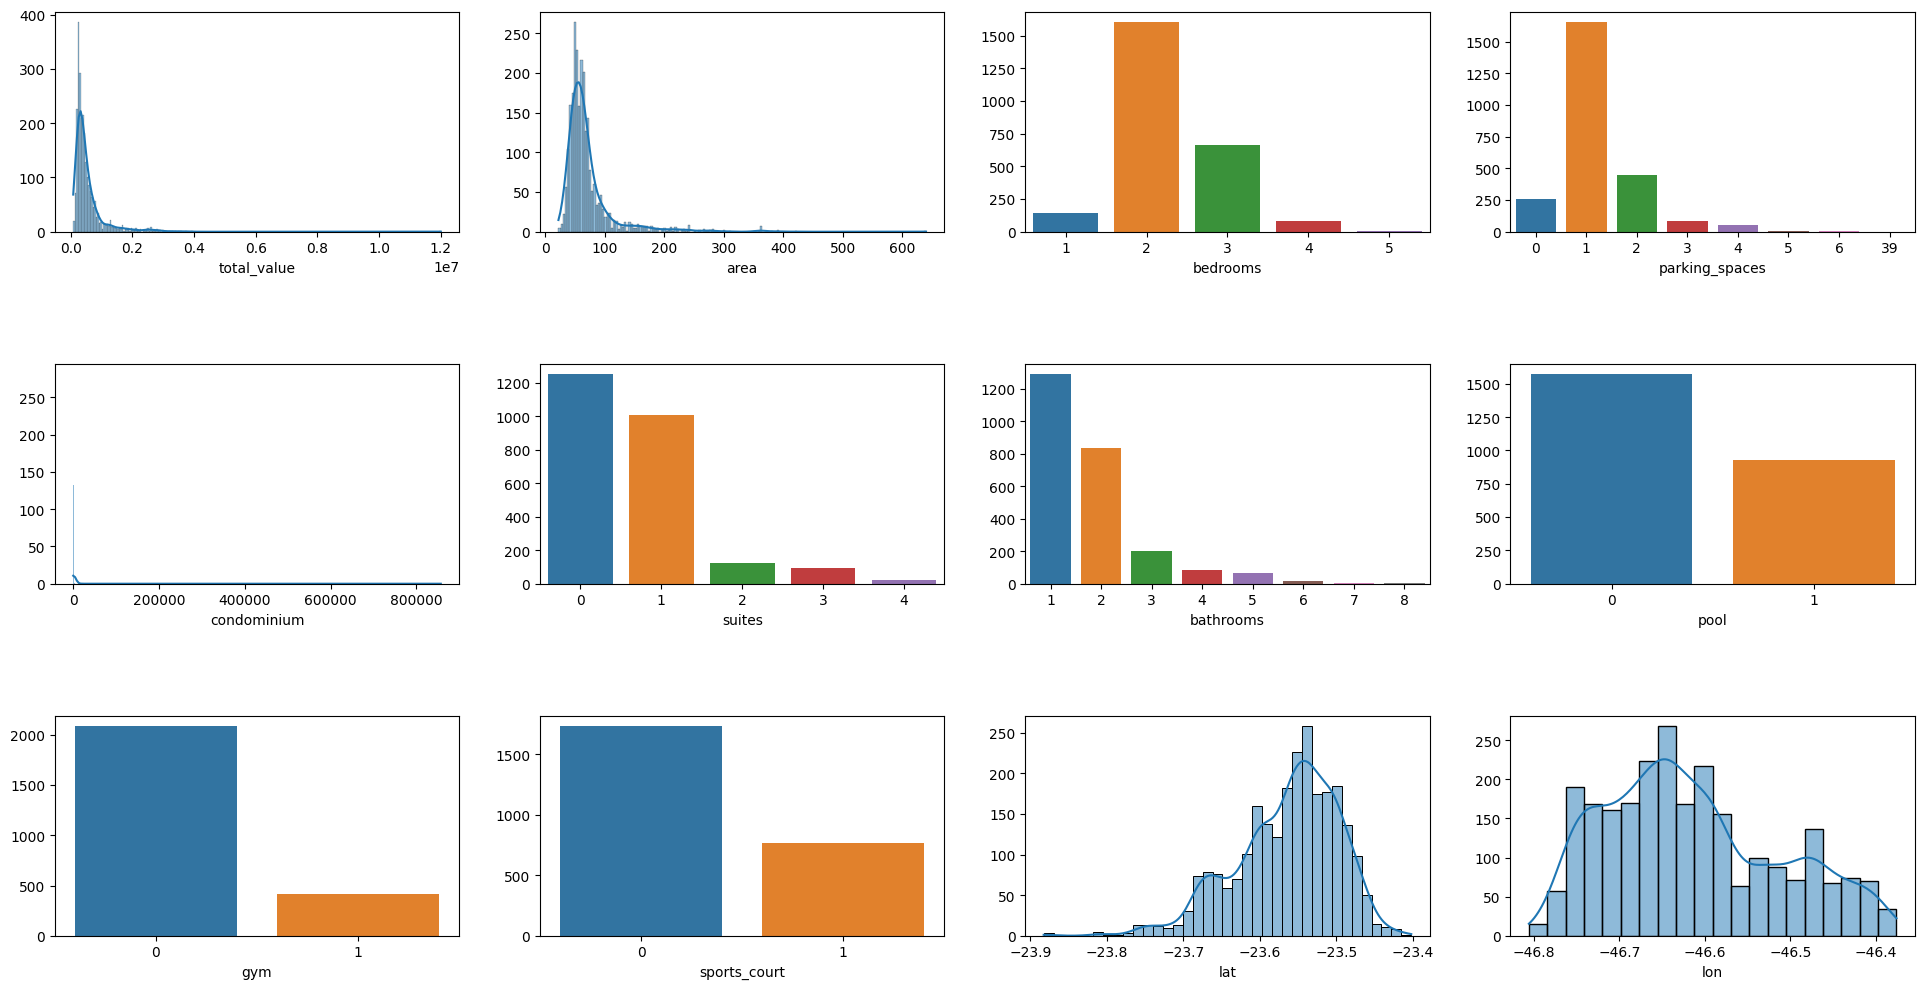

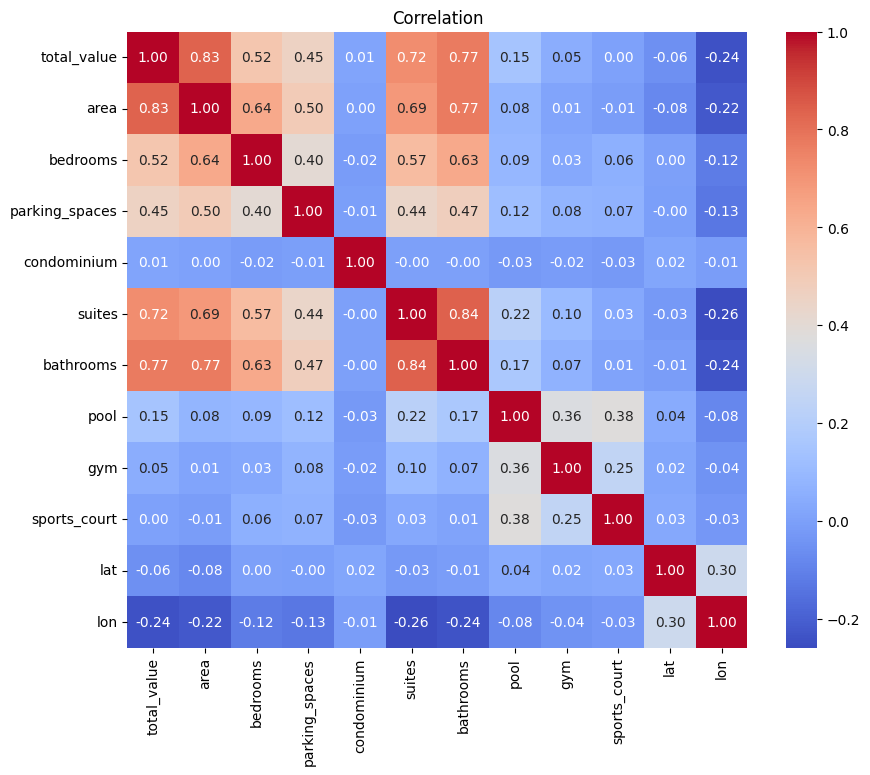

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar colunas numéricas
num_cols = treated_df.select_dtypes(include=['float64', 'int64']).columns

# Configuração dos subplots
num_plots_per_row = 4
num_rows = (len(num_cols) - 1) // num_plots_per_row + 1  # Cálculo do número de linhas necessário
fig, axes = plt.subplots(nrows=num_rows, ncols=num_plots_per_row, figsize=(6*num_plots_per_row, 4*num_rows))
plt.subplots_adjust(hspace=0.6)

# Loop para plotar mini gráficos
for i, col in enumerate(num_cols):
    row = i // num_plots_per_row
    col_idx = i % num_plots_per_row
    ax = axes[row, col_idx]
    
    # Verifica se a coluna é categórica ou numérica
    if len(treated_df[col].unique()) < 10:  # Número limite de categorias para considerar uma coluna como categórica
        sns.countplot(data=treated_df, x=col, ax=ax)
        ax.set_xlabel(col)
    else:
        sns.histplot(data=treated_df, x=col, ax=ax, kde=True)  # Crie histogramas com estimativa de densidade
        ax.set_xlabel(col)
        ax.set_ylabel('')  # Remova o rótulo do eixo Y
    
    ax.set_ylabel('')
    
# Preencher os subplots vazios na última linha (se houver)
for i in range(len(num_cols), num_rows * num_plots_per_row):
    row = i // num_plots_per_row
    col_idx = i % num_plots_per_row
    fig.delaxes(axes[row, col_idx])

# Matriz de Correlação
corr_matrix = treated_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation')

# Mostrar os gráficos
plt.show()


This code creates an HTML file for visualizing apartments from the dataset on a map. It uses the Folium library to generate an interactive map with markers representing apartment locations and their respective IDs and prices as pop-up information. The resulting map is saved as 'interactive_map.html.'

In [6]:
def create_html_map(df):
    """
    Create an HTML file for visualizing apartments from the dataset on a map.

    Parameters:
    df (DataFrame): DataFrame containing apartment data with 'lat' and 'lon' columns.

    Returns:
    None
    """
    # Create a map based on an initial location (latitude and longitude)
    m = folium.Map(location=[-23.53017888125, -46.6625586625], zoom_start=14)

    # Loop through the data in your DataFrame (assuming your DataFrame is named 'df')
    for index, row in df.iterrows():
        # Create a marker for each point
        marker = folium.Marker(
            location=[row['lat'], row['lon']],
            popup=f'ID: {row["id"]}<br>Price: ${row["valor_total"]}',  # Add the ID here
        )

        # Add the marker to the map
        marker.add_to(m)

    # Display the map
    m.save('interactive_map.html')  # This will save the map to an HTML file

create_html_map(df)

# Section 3: Data Preparation


To continue the analysis, we will check for null values in the dataframe that will be used.

In [7]:
# Verifying if the new dataframe have any NA values

treated_df.isnull().sum()

total_value         0
area                0
bedrooms            0
parking_spaces      0
condominium       235
suites              0
bathrooms           0
pool                0
gym                 0
sports_court        0
lat                 0
lon                 0
dtype: int64


Since there are null values, they will be treated. Considering that condominium fees are commonly associated with apartment properties in São Paulo, it is assumed that the missing values represent data flaws. Therefore, they will be treated by imputing the average overall value.

condominium column have now 0 NAN values


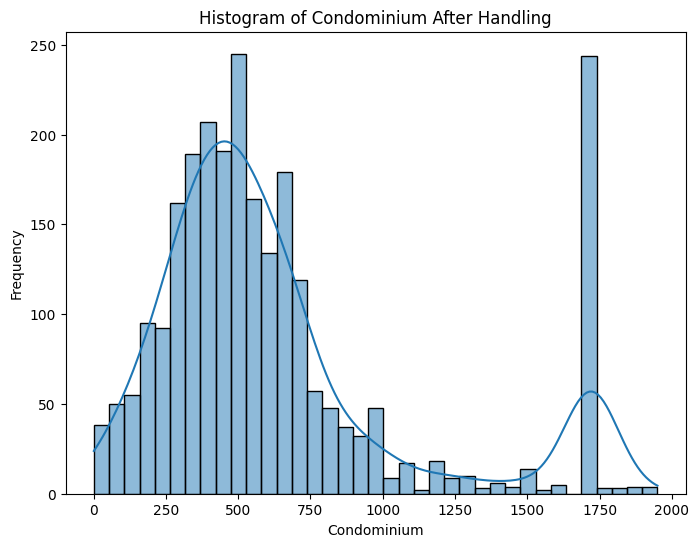

In [25]:
# Calculate the mean of the column
condominio_mean = treated_df['condominium'].mean(skipna=True)

condominio_std = treated_df['condominium'].std(skipna=True)

# Fill the NA values in the condominio column with the mean value
treated_df['condominium'].fillna(condominio_mean, inplace=True)

# Define the threshold for outliers (3 standard deviations away from the mean)
threshold = 3 * condominio_std

# Check if any value in the 'condominium' column is an outlier
outliers = treated_df['condominium'][np.abs(treated_df['condominium'] - condominio_mean) > threshold]

# If there are outliers, replace them with the mean
if not outliers.empty:
    treated_df.loc[outliers.index, 'condominium'] = condominio_mean

# Verifying if the new dataframe have any NA values
print('condominium column have now ' + str(treated_df['condominium'].isnull().sum()) + ' NAN values')

plt.figure(figsize=(8, 6))
sns.histplot(data=treated_df, x='condominium', kde=True)
plt.title('Histogram of Condominium After Handling')
plt.xlabel('Condominium')
plt.ylabel('Frequency')
plt.show()

In [19]:

# Calculate the mean and standard deviation of the 'condominium' column
condominio_mean = treated_df['condominium'].mean(skipna=True)




# Now, 'condominium' column in treated_df has outliers replaced with the mean


# Section 4: Analysis / Modeling

For this modeling phase, we will employ the Random Forest algorithm to predict apartment prices based on latitude and longitude coordinates. Random Forest is chosen as the model for several compelling reasons in this context. <br>
<br>
1. Handling Non-linearity: Random Forest is an ensemble learning method that consists of multiple decision trees. Each tree captures different aspects of the data, allowing the model to handle complex non-linear relationships effectively. In the context of predicting apartment prices, real estate markets often exhibit non-linear behavior where the influence of location (latitude and longitude) on price can be intricate and non-obvious. Random Forest excels in capturing these intricate patterns.<br>
<br>
2. Robust to Overfitting: Overfitting is a common concern in predictive modeling, especially when dealing with geographic data. Random Forest mitigates this risk by averaging predictions from multiple trees, thereby reducing the likelihood of fitting noise in the data. It provides a balance between bias and variance, making it a robust choice for modeling.<br>

3. Feature Importance: Random Forest provides a measure of feature importance. In our case, latitude and longitude are crucial features for predicting apartment prices, as location is a primary determinant of real estate value. Random Forest's feature importance score will help us validate that these geographic coordinates indeed have a significant impact on price predictions.<br>
<br>
4. Handling High-Dimensional Data: While we are primarily using latitude and longitude as input features, other features such as neighborhood statistics could also be incorporated. Random Forest can handle high-dimensional data gracefully and adapt to various feature types, making it a versatile choice.<br>
<br>
5. Ensemble Learning: The ensemble nature of Random Forest combines the predictions from multiple decision trees, reducing the risk of making predictions based on a single potentially biased model. This ensemble approach enhances the model's robustness and prediction accuracy.<br>
<br>
In summary, Random Forest is an excellent choice for predicting apartment prices based on latitude and longitude inputs due to its ability to capture non-linear relationships, handle overfitting, provide feature importance insights, adapt to high-dimensional data, and leverage ensemble learning techniques. By using Random Forest, we aim to build a reliable and accurate pricing model that takes full advantage of the geographic features in our dataset.






This code defines a function, train_and_evaluate_random_forest, to train and evaluate a Random Forest model for predicting apartment prices. It takes a DataFrame as input, selects relevant columns, splits the data into training and testing sets, fits the Random Forest model, makes predictions, evaluates the model using Mean Squared Error (MSE), and visualizes feature importance. This function provides a structured way to perform these tasks for apartment price prediction.

R-squared (R²) Score: 0.8553


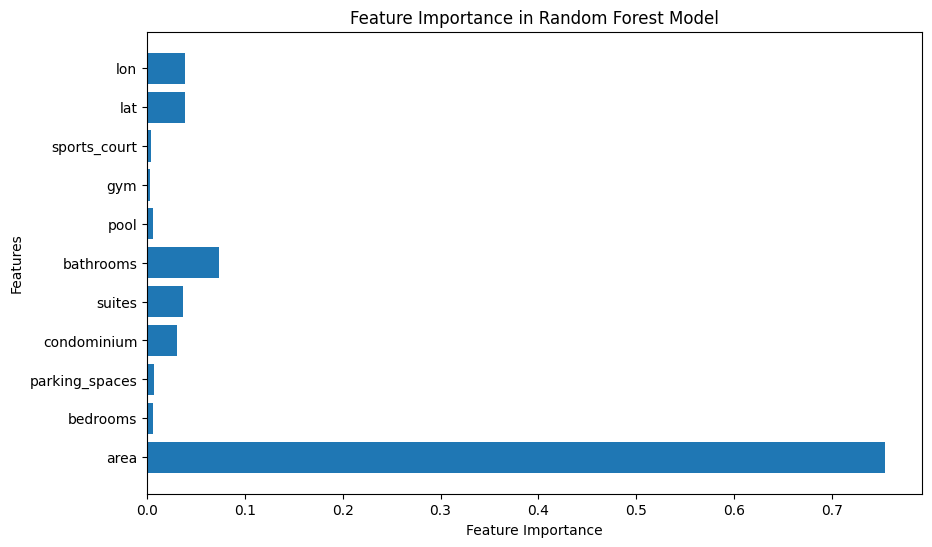

In [30]:


def train_and_evaluate_random_forest(df):
    """
    Train and evaluate a Random Forest model for predicting apartment prices.

    Parameters:
    df (DataFrame): DataFrame containing relevant columns including 'lat', 'lon', 'total_value', and others.

    Returns:
    None
    """
    # Define independent variables (X) and the dependent variable (Y)
    X = df[['area', 'bedrooms', 'parking_spaces', 'condominium', 'suites', 'bathrooms', 'pool', 'gym', 'sports_court', 'lat', 'lon']]
    Y = df['total_value']

    # Split the data into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Create and fit the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, Y_train)

    # Make predictions
    Y_pred = rf_model.predict(X_test)

    # Evaluate model performance using R-squared (R²)
    r2 = r2_score(Y_test, Y_pred)
    print(f'R-squared (R²) Score: {r2:.4f}')

    # Visualize feature importance
    feature_importances = rf_model.feature_importances_
    plt.figure(figsize=(10, 6))
    plt.barh(X.columns, feature_importances)
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title('Feature Importance in Random Forest Model')
    plt.show()

train_and_evaluate_random_forest(treated_df)


## Model Refinement

While the initial Random Forest model is a solid starting point, there's always room for improvement. In this refined version, we'll enhance the model's performance by incorporating feature preprocessing, including feature scaling for numerical features and one-hot encoding for categorical features. This preprocessing step helps the model better capture complex relationships in the data. Additionally, we'll provide more informative feature names for visualization.


R-squared (R²) Score: 0.8555


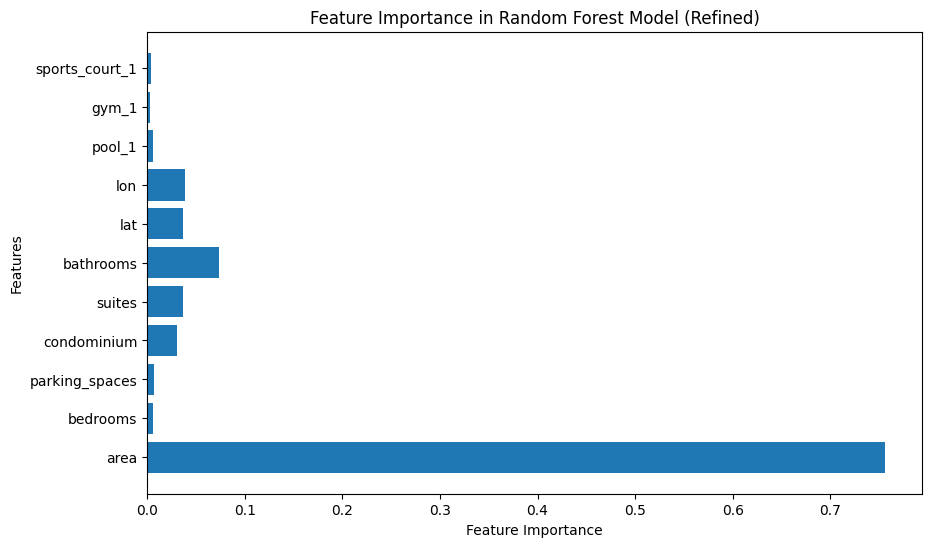

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score  # Import the R-squared metric

def train_and_evaluate_random_forest_refined(df):
    """
    Train and evaluate a refined Random Forest model for predicting apartment prices.

    Parameters:
    df (DataFrame): DataFrame containing relevant columns including 'lat', 'lon', 'total_value', and others.

    Returns:
    None
    """
    # Define independent variables (X) and the dependent variable (Y)
    X = df[['area', 'bedrooms', 'parking_spaces', 'condominium', 'suites', 'bathrooms', 'pool', 'gym', 'sports_court', 'lat', 'lon']]
    Y = df['total_value']

    # Split the data into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Feature preprocessing
    numeric_features = ['area', 'bedrooms', 'parking_spaces', 'condominium', 'suites', 'bathrooms', 'lat', 'lon']
    categorical_features = ['pool', 'gym', 'sports_court']

    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())  # Standardize numeric variables
    ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(drop='first', sparse=False))  # One-hot encoding for categorical variables
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Create and fit the Random Forest model with preprocessing
    rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', RandomForestRegressor(n_estimators=100, random_state=42))])

    rf_model.fit(X_train, Y_train)

    # Make predictions
    Y_pred = rf_model.predict(X_test)

    # Evaluate model performance using R-squared (R²)
    r2 = r2_score(Y_test, Y_pred)
    print(f'R-squared (R²) Score: {r2:.4f}')

    # Get the names of one-hot encoded categorical columns
    categorical_encoder = rf_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']

    # Get original categories
    original_categories = categorical_encoder.categories_

    # Create names for one-hot encoded categorical columns
    encoded_category_names = []
    for i, category_feature in enumerate(categorical_features):
        for category in original_categories[i][1:]:  # Start from the second value to avoid multicollinearity
            encoded_category_names.append(f'{category_feature}_{category}')

    # Combine the names of numeric and categorical columns
    feature_names = numeric_features + encoded_category_names

    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, rf_model.named_steps['model'].feature_importances_)
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title('Feature Importance in Random Forest Model (Refined)')
    plt.show()

train_and_evaluate_random_forest_refined(treated_df)


## Alternative model

A Geographic Regression Model, also known as Geographical Regression, is a statistical approach used in spatial analysis to examine relationships between geographic data and a dependent variable of interest. This method accounts for the spatial autocorrelation, which means that nearby locations tend to have similar characteristics or values. It utilizes spatially weighted predictors and spatial lag terms to model how the spatial arrangement of data points impacts the outcome variable. Geographic Regression Models are valuable tools in various fields, such as epidemiology, urban planning, and environmental science, as they allow researchers to explore and quantify the spatial patterns and dependencies within data, helping to uncover meaningful insights for informed decision-making and policy development.

In [32]:
# Create a GeoDataFrame from latitude and longitude data
gdf = gpd.GeoDataFrame(treated_df, geometry=gpd.points_from_xy(treated_df.lon, treated_df.lat))

# Generate the spatial weights matrix based on Euclidean distance
w = libpysal.weights.DistanceBand.from_dataframe(gdf, threshold=0.1)

# Normalize the spatial weights matrix
w.transform = 'R'

# Separate independent variables (X) and the dependent variable (Y)
X = treated_df[['area', 'bedrooms', 'parking_spaces', 'condominium', 'suites', 'bathrooms', 'pool', 'gym', 'sports_court', 'lat', 'lon']]
Y = treated_df['total_value']

# Add a constant term to X
X = sm.add_constant(X)

# Convert X and Y to NumPy arrays
X = X.to_numpy()
Y = Y.to_numpy()

# Create and fit the spatial linear regression model using spreg.OLS
spatial_lm = OLS(Y, X, w, spat_diag=True, name_y='total_value', name_x=['const', 'area', 'bedrooms', 'parking_spaces', 'condominium', 'suites', 'bathrooms', 'pool', 'gym', 'sports_court', 'lat', 'lon'])
results = spatial_lm
print(results.summary)


('WARNING: ', 376, ' is an island (no neighbors)')
('WARNING: ', 377, ' is an island (no neighbors)')
('WARNING: ', 378, ' is an island (no neighbors)')
REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  : total_value                Number of Observations:        2499
Mean dependent var  : 548085.2049                Number of Variables   :          12
S.D. dependent var  : 554448.7191                Degrees of Freedom    :        2487
R-squared           :      0.7543
Adjusted R-squared  :      0.7532
Sum squared residual:188659840931489.062                F-statistic           :    694.1867
Sigma-square        :75858400052.871                Prob(F-statistic)     :           0
S.E. of regression  :  275424.037                Log likelihood        :  -34842.555
Sigma-square ML     :75494134026.206                Akaike info criterion :   69709.1

## Implementation

After refining our model, we observed a improvement in Rˆ2, indicating better predictive performance. Therefore, we will use this refined model for implementation. In this section, we will explain how to use the model to predict the total value of an apartment based on user-provided inputs.

In [11]:
# Define independent variables (X) and the dependent variable (Y)
X = treated_df[['area', 'bedrooms', 'parking_spaces', 'condominium', 'suites', 'bathrooms', 'pool', 'gym', 'sports_court', 'lat', 'lon']]
Y = treated_df['total_value']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Feature preprocessing
numeric_features = ['area', 'bedrooms', 'parking_spaces', 'condominium', 'suites', 'bathrooms', 'lat', 'lon']
categorical_features = ['pool', 'gym', 'sports_court']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Standardize numeric variables
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse=False))  # One-hot encoding for categorical variables
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create and fit the Random Forest model with preprocessing
rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', RandomForestRegressor(n_estimators=100, random_state=42))])

rf_model.fit(X_train, Y_train)

# Make predictions
Y_pred = rf_model.predict(X_test)

In [12]:
# Prompt the user to provide integer values for each variable
area = int(input("Enter the area (integer value): "))
bedrooms = int(input("Enter the number of bedrooms (integer value): "))
parking_spaces = int(input("Enter the number of parking spaces (integer value): "))
cond = float(input("Enter the condominium value (floating-point number): "))
suites = int(input("Enter the number of suites (integer value): "))
bathrooms = int(input("Enter the number of bathrooms (integer value): "))
pool = int(input("Does it have a pool? (integer value): "))
gym = int(input("Does it have a gym? (integer value): "))
sports_court = int(input("Does it have a sports court? (integer value): "))
cep = str(input("Enter the CEP (use separator): "))

# Get latitude and longitude using CEP
geolocator = Nominatim(user_agent="geoapiExercises")
location = geolocator.geocode(cep)

# Create a DataFrame with the user's inputs
data = pd.DataFrame({
    'area': [area],
    'bedrooms': [bedrooms],
    'parking_spaces': [parking_spaces],
    'condominium': [cond],
    'suites': [suites],
    'bathrooms': [bathrooms],
    'pool': [pool],
    'gym': [gym],
    'sports_court': [sports_court],
    'lat': [location.latitude],
    'lon': [location.longitude]
})

# Use the Random Forest model to predict total_value
X = data[['area', 'bedrooms', 'parking_spaces', 'condominium', 'suites', 'bathrooms', 'pool', 'gym', 'sports_court', 'lat', 'lon']]
total_value_predicted = rf_model.predict(X)

# Display the predicted total value
print("The predicted total value is:", total_value_predicted[0])


ValueError: invalid literal for int() with base 10: ''

### Implementation Explanation: 
<br>
The user is prompted to input specific details about the apartment, including its area, the number of bedrooms, parking spaces, condominium value, suites, bathrooms, and whether it has a pool, gym, or sports court.<br>
<br>
Additionally, the user is asked to provide the CEP (Postal Code) as a separator. This CEP is then used to obtain latitude and longitude coordinates of the apartment's location using the GeoPy library.<br>
<br>
The user's input is organized into a DataFrame.<br>
<br>
The Random Forest model (previously trained and refined) is used to predict the total value of the apartment based on the user's input.<br>
<br>
Finally, the predicted total value is displayed to the user.<br>
<br>
This implementation allows users to quickly estimate the total value of an apartment in São Paulo by providing essential details and location information.